<a href="https://colab.research.google.com/github/gourav10/autoencoder_embedding/blob/main/triplet_loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General Imports and Model definations

In [1]:
from google.colab import drive
import os

In [2]:
import pandas as pd
import numpy as np
import time
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
%cd /content/gdrive/MyDrive/CS7180

/content/gdrive/MyDrive/CS7180


## Data Prep. for Encoder Training using Triplet Loss

In [6]:
train_df = pd.read_csv('/content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST/mnist_train.csv')
test_df = pd.read_csv('/content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST/mnist_test.csv')

In [7]:
torch.manual_seed(2020)
np.random.seed(2020)
random.seed(2020)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [8]:
train_df.head()

,5,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.608,0.609,0.610,0.611,0.612,0.613,0.614,0.615,0.616,0.617
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_df.rename(columns={'5':'label'},inplace=True)

In [10]:
test_df.rename(columns={'7':'label'},inplace=True)

In [11]:
test_df.head()

,label,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Define Triplet Dataset

In [12]:
class Triplet_MNIST(Dataset):
    def __init__(self, df, is_train=True,transform = None):
        self.is_train = is_train
        self.transform = transform
        self.to_pil = transforms.ToPILImage()
        
        if self.is_train:
            self.images = df.iloc[:,1:].values.astype(np.uint8)
            self.labels = df.iloc[:,0].values
            self.index = df.index.values
        else:
            self.images = df.values.astype(np.uint8)
            
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        anchor_img = self.images[index].reshape(28,28,1)
        
        if self.is_train:
            anchor_label = self.labels[index]
            
            positive_list = self.index[self.index!=index][self.labels[self.index!=index]==anchor_label]
            positive_item = random.choice(positive_list)
            positive_img = self.images[positive_item].reshape(28,28,1)
            
            negative_list = self.index[self.index!=index][self.labels[self.index!=index]!=anchor_label]
            negative_item = random.choice(negative_list)
            negative_img = self.images[negative_item].reshape(28, 28, 1)
            
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
                positive_img = self.transform(self.to_pil(positive_img))
                negative_img = self.transform(self.to_pil(negative_img))
            
            return anchor_img, positive_img, negative_img, anchor_label
        else:
            if self.transform:
                anchor_img = self.transform(self.to_pil(anchor_img))
            return anchor_img

In [13]:
train_ds = Triplet_MNIST(train_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))

In [14]:
batch_size = 32
epochs = 50

In [15]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)
from torchvision import datasets

# Define Model

In [16]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim,
                 fc2_input_dim,
                 in_channels=1) -> None:
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            # 1st convolutional layer
            nn.Conv2d(in_channels, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            # 2nd Convolutional Layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # 3rd Convolutional Layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_linear = nn.Sequential(
            nn.Linear(3*3*32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_linear(x)
        return x


class Decoder(nn.Module):
    def __init__(self, encoded_space_dim, out_channels=1) -> None:
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3*3*32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        # Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the
        # output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x


## Helper Methods

In [17]:
def generate_embeddings(encoder, test_data, device):
  encoded_samples = []
  for sample in tqdm(test_data):
      img = sample[0].unsqueeze(0).to(device)
      label = sample[1]
      # Encode image
      encoder.eval()
      with torch.no_grad():
          encoded_img  = encoder(img)
      # Append to list
      encoded_img = encoded_img.flatten().cpu().numpy()
      encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
      encoded_sample['label'] = label
      encoded_samples.append(encoded_sample)
  return encoded_samples

In [18]:
def visualize_embeddings_2D(x_values, y_values, labels, experiment_name):
    plt.figure(figsize=(17, 9))
    plt.scatter(x_values, y_values, c=labels, cmap="tab10")
    plt.colorbar()
    plt.title(experiment_name)
    plt.show()

In [19]:
def save_model(model, model_name=''):
    os.makedirs('temp', exist_ok=True)
    dest_path_encoder = os.path.join('temp', f'{model_name}.pt')
    torch.jit.save(model, dest_path_encoder)

In [20]:
def visualize_clustering_2D(x_values, y_values, labels, centers, experiment_name):
    plt.figure(figsize=(17, 9))
    plt.scatter(x_values, y_values, c=labels, cmap="tab10")
    plt.colorbar()
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    plt.title(experiment_name)
    plt.show()

# Model 1: Autoencoder with latent space dimension 4

In [15]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Train Encoder: Using Triplet Loss

In [ ]:
model = Encoder(encoded_space_dim=4,fc2_input_dim=128)
model = torch.jit.script(model).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

criterion = torch.jit.script(torch.nn.TripletMarginLoss())

In [ ]:
model.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = []
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = model(anchor_img)
        positive_out = model(positive_img)
        negative_out = model(negative_img)
        
        loss = criterion(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()
        
        running_loss.append(loss.cpu().detach().numpy())
    print("Epoch: {}/{} - Loss: {:.4f}".format(epoch+1, epochs, np.mean(running_loss)))

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 1/50 - Loss: 0.1090


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 2/50 - Loss: 0.0377


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 3/50 - Loss: 0.0296


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 4/50 - Loss: 0.0240


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 5/50 - Loss: 0.0218


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 6/50 - Loss: 0.0179


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 7/50 - Loss: 0.0167


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 8/50 - Loss: 0.0175


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 9/50 - Loss: 0.0163


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 10/50 - Loss: 0.0135


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 11/50 - Loss: 0.0140


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 12/50 - Loss: 0.0136


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 13/50 - Loss: 0.0123


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 14/50 - Loss: 0.0112


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 15/50 - Loss: 0.0123


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 16/50 - Loss: 0.0117


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 17/50 - Loss: 0.0106


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 18/50 - Loss: 0.0110


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 19/50 - Loss: 0.0102


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 20/50 - Loss: 0.0099


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 21/50 - Loss: 0.0103


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 22/50 - Loss: 0.0087


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 23/50 - Loss: 0.0097


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 24/50 - Loss: 0.0090


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 25/50 - Loss: 0.0080


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 26/50 - Loss: 0.0080


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 27/50 - Loss: 0.0084


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 28/50 - Loss: 0.0075


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 29/50 - Loss: 0.0077


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 30/50 - Loss: 0.0074


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 31/50 - Loss: 0.0074


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 32/50 - Loss: 0.0073


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 33/50 - Loss: 0.0078


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 34/50 - Loss: 0.0078


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 35/50 - Loss: 0.0073


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 36/50 - Loss: 0.0064


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 37/50 - Loss: 0.0063


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 38/50 - Loss: 0.0078


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 39/50 - Loss: 0.0066


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 40/50 - Loss: 0.0066


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 41/50 - Loss: 0.0064


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 42/50 - Loss: 0.0055


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 43/50 - Loss: 0.0065


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 44/50 - Loss: 0.0064


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 45/50 - Loss: 0.0062


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 46/50 - Loss: 0.0063


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 47/50 - Loss: 0.0059


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 48/50 - Loss: 0.0064


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 49/50 - Loss: 0.0044


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 50/50 - Loss: 0.0054


In [ ]:
%cd '/content/gdrive/MyDrive/CS7180/autoencoder_embedding/'

/content/gdrive/MyDrive/CS7180/autoencoder_embedding


In [ ]:
!pwd

/content/gdrive/MyDrive/CS7180/autoencoder_embedding


In [ ]:
save_model(model, 'best_encoder')

## Train Decoder: Using MSE Loss

In [36]:
DATA_DIR = '/content/gdrive/MyDrive/CS7180/autoencoder_embedding/data/MNIST'

In [37]:
import os
os.makedirs(DATA_DIR,exist_ok=True)

In [38]:
train_data = datasets.MNIST(root=DATA_DIR, train=True, download=True)
test_data = datasets.MNIST(root=DATA_DIR, train=False, download=True)

In [ ]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=4)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:563: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


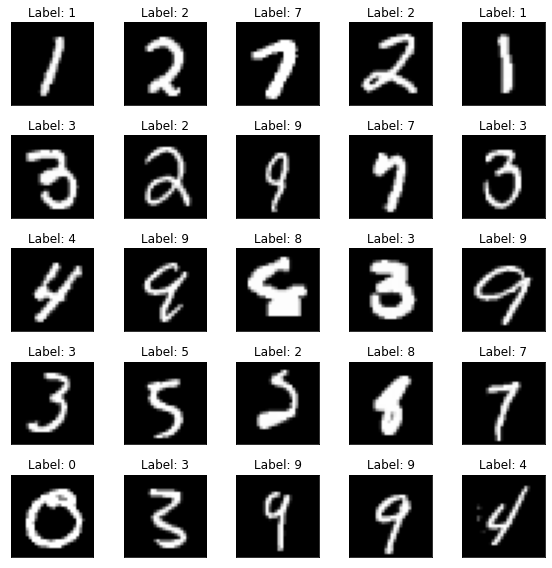

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_data)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title('Label: %d' % label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

In [41]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_data.transform = train_transform
# Set the test transform
test_data.transform = test_transform

In [ ]:
m=len(train_data)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_data, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=True)

In [ ]:
decoder = Decoder(encoded_space_dim=4)

In [ ]:
### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001
#lr = 0.0008 # Learning rate


params_to_optimize = [
    {'params': model.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

In [ ]:
def __train(dataloader, loss_fn, optimizer,encoder,decoder):
    encoder.eval()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_batch = image_batch.to(device)
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [ ]:
def __validate(dataloader, loss_fn, encoder, decoder):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            image_batch = image_batch.to(device)
            encoded_data = encoder(image_batch)
            decoded_data = decoder(encoded_data)
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.item()

In [ ]:
def train_model(model_name, train_dl,
                test_dl, loss_fn, optimizer,
                encoder, decoder, device, num_epochs):
    # encoder = encoder.to(device)
    history = {}
    encoder = torch.jit.script(encoder).to(device)
    # decoder = decoder.to(device)
    decoder = torch.jit.script(decoder).to(device)
    loss_fn = torch.jit.script(loss_fn)
    history = {'train_loss': [], 'val_loss': []}
    min_loss = float('inf')
    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        train_loss = __train(train_dl, loss_fn, optimizer,encoder,decoder)
        val_loss = __validate(test_dl, loss_fn,encoder,decoder)

        if (epoch % 5 == 0):
            print('\n EPOCH {}/{} \t train loss{:.3f} \t val loss {:.3f}'
                  .format(epoch + 1, num_epochs,
                          train_loss, val_loss))

        if (epoch % 10 == 0):
            save_model(decoder, model_name=f'model_{model_name}_{epoch}')

        if (min_loss > val_loss):
            min_loss = val_loss
            save_model(decoder, model_name=f'best_{model_name}')

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
    return history

In [ ]:
history = train_model("decoder",
                      train_loader,
                      valid_loader,
                      loss_fn,
                      optim,
                      model,
                      decoder,
                      device,
                      epochs)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]


 EPOCH 1/50 	 train loss0.040 	 val loss 0.039

 EPOCH 6/50 	 train loss0.032 	 val loss 0.032

 EPOCH 11/50 	 train loss0.027 	 val loss 0.027

 EPOCH 16/50 	 train loss0.026 	 val loss 0.027

 EPOCH 21/50 	 train loss0.026 	 val loss 0.026

 EPOCH 26/50 	 train loss0.025 	 val loss 0.026

 EPOCH 31/50 	 train loss0.025 	 val loss 0.026

 EPOCH 36/50 	 train loss0.025 	 val loss 0.026

 EPOCH 41/50 	 train loss0.025 	 val loss 0.026

 EPOCH 46/50 	 train loss0.025 	 val loss 0.026


In [ ]:
def plot_train_loss(history, title=""):
    plt.figure(figsize=(10, 8))
    plt.semilogy(history['train_loss'], label='Train')
    plt.semilogy(history['val_loss'], label='Valid')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend(history.keys())
    plt.title(title)
    plt.show()

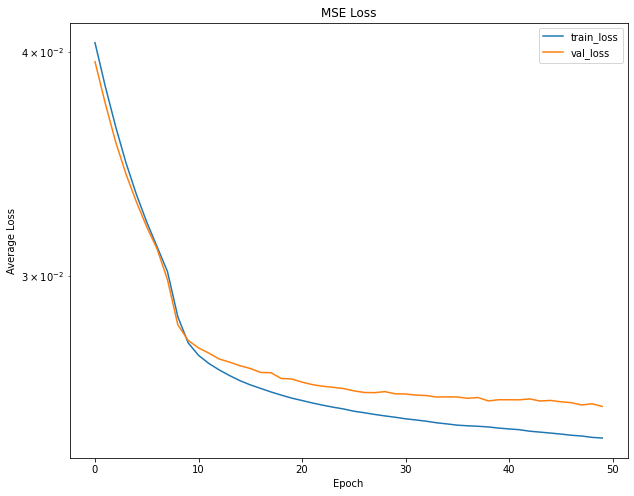

In [ ]:
plot_train_loss(history,"MSE Loss")

## Generate Latent Space Embeddings

In [ ]:
encoded_samples = generate_embeddings(model, test_data, device)
encoded_samples = pd.DataFrame(encoded_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
encoded_samples.head()

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,-0.116742,0.510713,-0.420934,-1.086748,7
1,-0.232264,0.950587,-0.268073,0.280601,2
2,-0.144756,0.599789,-1.387247,0.281433,1
3,-0.009789,-0.349136,0.530104,0.240376,0
4,0.512358,-1.045230,-0.658411,-0.428718,4


In [ ]:
def visualize_embeddings_2D(x_values, y_values, labels, experiment_name):
    plt.figure(figsize=(17, 9))
    plt.scatter(x_values, y_values, c=labels, cmap="tab10")
    plt.colorbar()
    plt.title(experiment_name)
    plt.show()

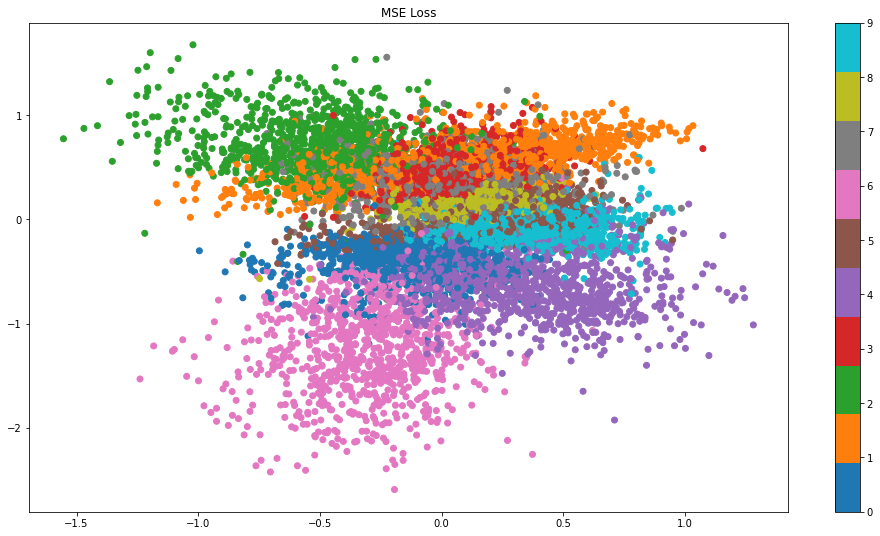

In [ ]:
visualize_embeddings_2D(encoded_samples['Enc. Variable 0'], 
                        encoded_samples['Enc. Variable 1'],
                        encoded_samples.label, "MSE Loss")

## Reduce Dimension

In [51]:
def cluster_latent_space(clustering_model, embedding_df, experiment_name):
    clustering_results = clustering_model.fit_transform(
        embedding_df.drop(["label"], axis=1)
    )
    visualize_embeddings_2D(
        clustering_results[:, 0], clustering_results[:, 1], embedding_df.label,
        experiment_name
    )
    return clustering_results

In [52]:
from sklearn.manifold import TSNE

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


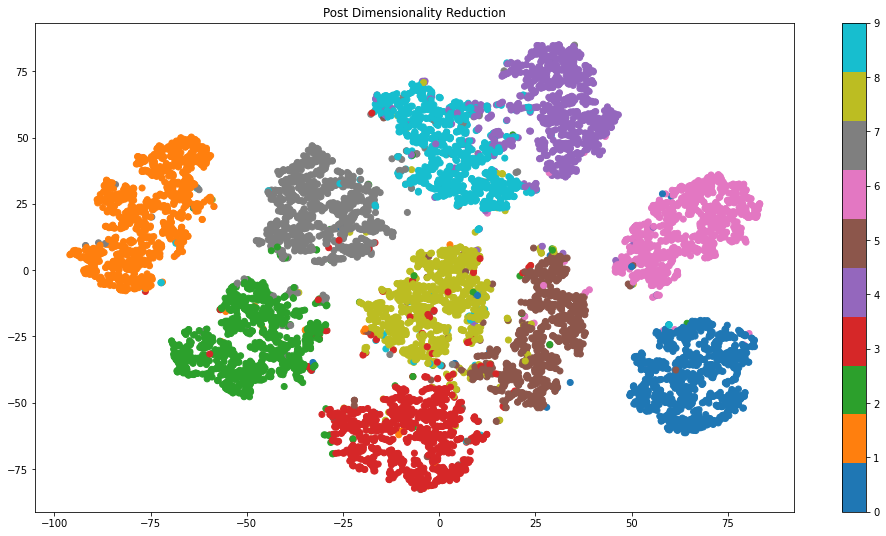

In [ ]:
%time
tsne = TSNE(n_components=2,init = 'pca')
clustering_results = cluster_latent_space(tsne, encoded_samples, "Post Dimensionality Reduction")

In [ ]:
clustering_results
dftsne = pd.DataFrame(clustering_results)

In [ ]:
dftsne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10000 non-null  float32
 1   1       10000 non-null  float32
dtypes: float32(2)
memory usage: 78.2 KB


In [ ]:
len(encoded_samples.label)
dftsne['cluster'] = encoded_samples.label

In [ ]:
dftsne.head()

,0,1,cluster
0,-41.176197,26.459539,7
1,-54.092594,-15.196441,2
2,-86.825378,31.317444,1
3,55.188381,-35.564960,0
4,30.832235,65.356796,4


In [ ]:
dftsne.columns

Index([0, 1, 'cluster'], dtype='object')

In [ ]:
dftsne[0]

0      -41.176197
1      -54.092594
2      -86.825378
3       55.188381
4       30.832235
          ...    
9995   -39.328590
9996    -9.387300
9997    32.881695
9998    28.458101
9999    60.648338
Name: 0, Length: 10000, dtype: float32

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
cluster_labels = kmeans.fit_predict(dftsne)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
centers = kmeans.cluster_centers_

In [ ]:
def visualize_clustering_2D(x_values, y_values, labels, centers, experiment_name):
    plt.figure(figsize=(17, 9))
    plt.scatter(x_values, y_values, c=labels, cmap="tab10")
    plt.colorbar()
    plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
    plt.title(experiment_name)
    plt.show()

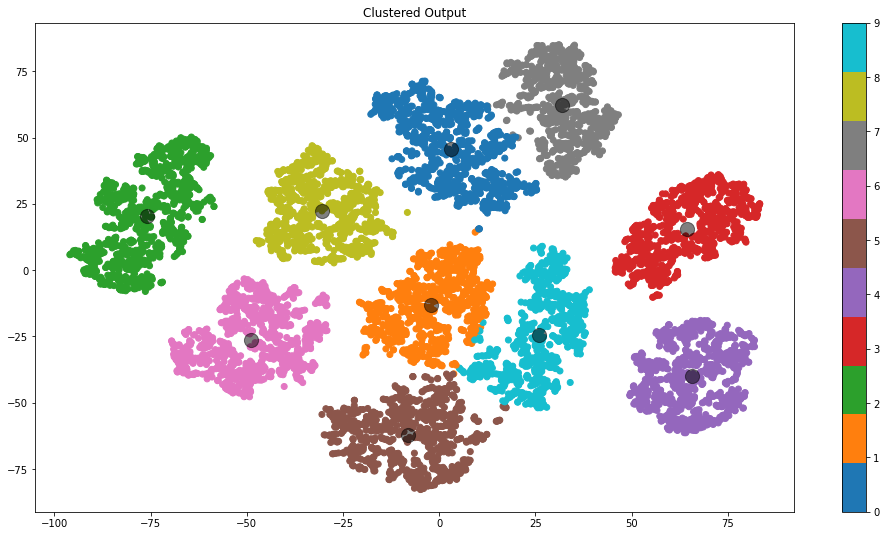

In [ ]:
visualize_clustering_2D(dftsne[0],dftsne[1],cluster_labels,centers, "Clustered Output")

# Model 2: Autoencoder with latent space dimension 5

## Initialize Autoencoder

In [17]:
encoder = Encoder(encoded_space_dim=5,fc2_input_dim=128)
encoder = torch.jit.script(encoder).to(device)

decoder = Decoder(encoded_space_dim=5)
decoder = torch.jit.script(decoder).to(device)

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [19]:
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = torch.optim.Adam(params_to_optimize, lr=0.001)

criterion_encoder = torch.jit.script(torch.nn.TripletMarginLoss())
criterion_decoder = torch.jit.script(torch.nn.MSELoss())

## Model Training

In [23]:
train_ds = Triplet_MNIST(train_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
test_ds = Triplet_MNIST(test_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

In [24]:
epochs

50

In [28]:
encoder.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = {'mse':[],
                    'triplet':[]
                   }
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = encoder(anchor_img)
        positive_out = encoder(positive_img)
        negative_out = encoder(negative_img)
        
        decoded_data = decoder(anchor_out)
        loss = criterion_encoder(anchor_out, positive_out, negative_out)

        loss_decoder = criterion_decoder(decoded_data, anchor_img)
        
        loss#.backward()
        loss_decoder.backward()

        optimizer.step()
        
        running_loss['triplet'].append(loss.cpu().detach().numpy())
        running_loss['mse'].append(loss_decoder.cpu().detach().numpy())
    print("Epoch: {}/{} - Triplet Loss: {:.4f} - MSE Loss: {:.4f}".format(epoch+1, epochs, np.mean(np.array(running_loss['triplet'])),np.mean(np.array(running_loss['mse']))))

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 1/50 - Triplet Loss: 0.3989 - MSE Loss: 0.0295


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 2/50 - Triplet Loss: 0.3714 - MSE Loss: 0.0271


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 3/50 - Triplet Loss: 0.3586 - MSE Loss: 0.0261


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 4/50 - Triplet Loss: 0.3536 - MSE Loss: 0.0254


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 5/50 - Triplet Loss: 0.3462 - MSE Loss: 0.0249


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 6/50 - Triplet Loss: 0.3413 - MSE Loss: 0.0246


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 7/50 - Triplet Loss: 0.3449 - MSE Loss: 0.0243


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 8/50 - Triplet Loss: 0.3479 - MSE Loss: 0.0240


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 9/50 - Triplet Loss: 0.3404 - MSE Loss: 0.0238


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 10/50 - Triplet Loss: 0.3432 - MSE Loss: 0.0236


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 11/50 - Triplet Loss: 0.3490 - MSE Loss: 0.0235


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 12/50 - Triplet Loss: 0.3421 - MSE Loss: 0.0233


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 13/50 - Triplet Loss: 0.3446 - MSE Loss: 0.0232


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 14/50 - Triplet Loss: 0.3458 - MSE Loss: 0.0231


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 15/50 - Triplet Loss: 0.3426 - MSE Loss: 0.0230


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 16/50 - Triplet Loss: 0.3468 - MSE Loss: 0.0229


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 17/50 - Triplet Loss: 0.3491 - MSE Loss: 0.0228


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 18/50 - Triplet Loss: 0.3465 - MSE Loss: 0.0227


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 19/50 - Triplet Loss: 0.3467 - MSE Loss: 0.0226


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 20/50 - Triplet Loss: 0.3455 - MSE Loss: 0.0225


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 21/50 - Triplet Loss: 0.3523 - MSE Loss: 0.0224


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 22/50 - Triplet Loss: 0.3608 - MSE Loss: 0.0224


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 23/50 - Triplet Loss: 0.3464 - MSE Loss: 0.0223


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 24/50 - Triplet Loss: 0.3544 - MSE Loss: 0.0223


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 25/50 - Triplet Loss: 0.3598 - MSE Loss: 0.0222


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 26/50 - Triplet Loss: 0.3633 - MSE Loss: 0.0222


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 27/50 - Triplet Loss: 0.3604 - MSE Loss: 0.0221


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 28/50 - Triplet Loss: 0.3499 - MSE Loss: 0.0221


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 29/50 - Triplet Loss: 0.3622 - MSE Loss: 0.0220


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 30/50 - Triplet Loss: 0.3576 - MSE Loss: 0.0220


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 31/50 - Triplet Loss: 0.3617 - MSE Loss: 0.0219


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 32/50 - Triplet Loss: 0.3653 - MSE Loss: 0.0219


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 33/50 - Triplet Loss: 0.3637 - MSE Loss: 0.0218


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 34/50 - Triplet Loss: 0.3620 - MSE Loss: 0.0218


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 35/50 - Triplet Loss: 0.3643 - MSE Loss: 0.0218


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 36/50 - Triplet Loss: 0.3646 - MSE Loss: 0.0217


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 37/50 - Triplet Loss: 0.3666 - MSE Loss: 0.0217


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 38/50 - Triplet Loss: 0.3697 - MSE Loss: 0.0217


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 39/50 - Triplet Loss: 0.3699 - MSE Loss: 0.0216


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 40/50 - Triplet Loss: 0.3745 - MSE Loss: 0.0216


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 41/50 - Triplet Loss: 0.3656 - MSE Loss: 0.0216


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 42/50 - Triplet Loss: 0.3691 - MSE Loss: 0.0215


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 43/50 - Triplet Loss: 0.3666 - MSE Loss: 0.0215


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 44/50 - Triplet Loss: 0.3664 - MSE Loss: 0.0215


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 45/50 - Triplet Loss: 0.3721 - MSE Loss: 0.0215


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 46/50 - Triplet Loss: 0.3709 - MSE Loss: 0.0214


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 47/50 - Triplet Loss: 0.3650 - MSE Loss: 0.0214


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 48/50 - Triplet Loss: 0.3717 - MSE Loss: 0.0214


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 49/50 - Triplet Loss: 0.3695 - MSE Loss: 0.0214


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 50/50 - Triplet Loss: 0.3795 - MSE Loss: 0.0213


In [31]:
save_model(encoder, model_name='encoder_embed5')
save_model(decoder, model_name='decoder_embed5')

## Generate Embeddings

In [42]:
train_data = datasets.MNIST(root=DATA_DIR, train=True, download=True)
test_data = datasets.MNIST(root=DATA_DIR, train=False, download=True)
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_data.transform = train_transform
# Set the test transform
test_data.transform = test_transform

In [44]:
encoded_samples = generate_embeddings(encoder, test_data, device)
encoded_samples = pd.DataFrame(encoded_samples)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [45]:
encoded_samples.head()

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,label
0,-0.329049,-3.277833,-4.958692,-1.321874,3.818638,7
1,7.752942,2.654190,-2.432112,-1.531075,-1.592486,2
2,0.014062,0.105372,-2.955912,2.455175,-0.854064,1
3,3.079295,0.146956,6.480844,-1.614475,-0.925424,0
4,-1.183128,-5.949833,3.541808,0.674402,-1.481602,4


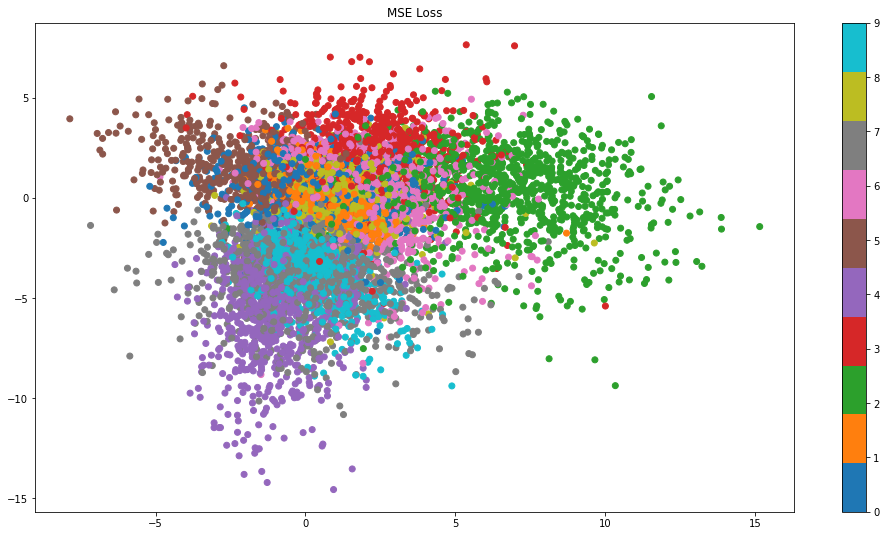

In [50]:
visualize_embeddings_2D(encoded_samples['Enc. Variable 0'], 
                        encoded_samples['Enc. Variable 1'],
                        encoded_samples.label, "MSE Loss")

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


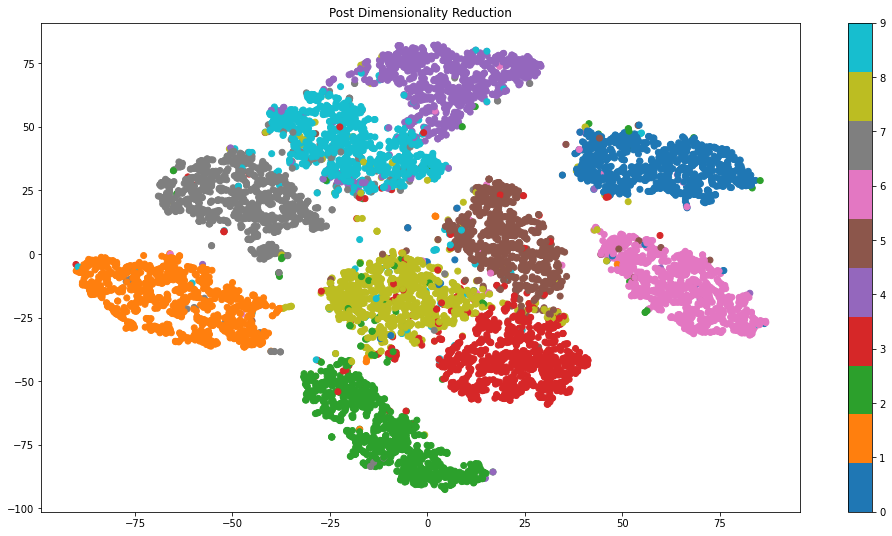

In [53]:
%time
tsne = TSNE(n_components=2,init = 'pca')
clustering_results = cluster_latent_space(tsne, encoded_samples, "Post Dimensionality Reduction")

In [54]:
clustering_results
dftsne = pd.DataFrame(clustering_results)

In [55]:
len(encoded_samples.label)
dftsne['cluster'] = encoded_samples.label

In [56]:
dftsne.head()

,0,1,cluster
0,-55.002689,15.190001,7
1,-14.247301,-57.090942,2
2,-63.953522,-22.509701,1
3,48.935368,24.461189,0
4,11.376995,75.017113,4


In [57]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10)
cluster_labels = kmeans.fit_predict(dftsne)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [59]:
centers = kmeans.cluster_centers_

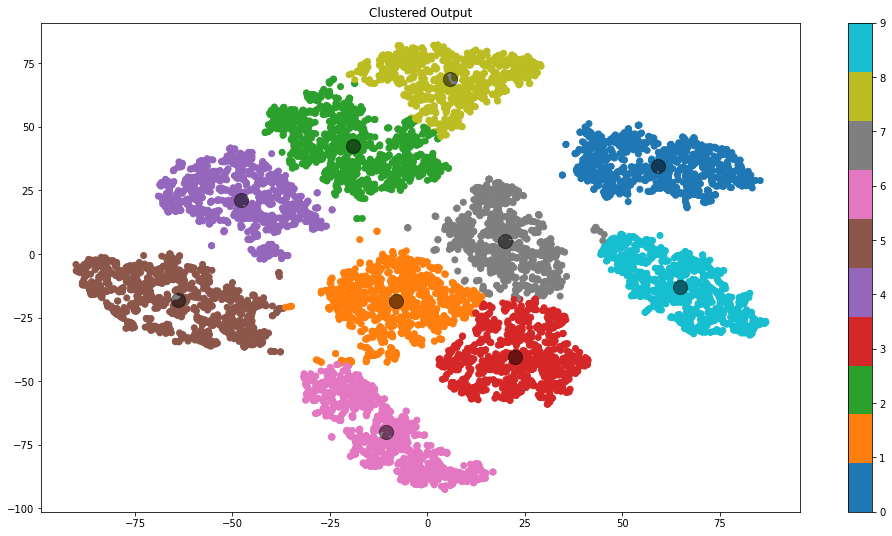

In [60]:
visualize_clustering_2D(dftsne[0],dftsne[1],cluster_labels,centers, "Clustered Output")

# Model 3: Autoencoder latent space embeddings 6

In [21]:
encoder = Encoder(encoded_space_dim=6,fc2_input_dim=128)
encoder = torch.jit.script(encoder).to(device)

decoder = Decoder(encoded_space_dim=6)
decoder = torch.jit.script(decoder).to(device)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == "cuda":
    torch.cuda.get_device_name()

In [23]:
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]
optimizer = torch.optim.Adam(params_to_optimize, lr=0.001)

criterion_encoder = torch.jit.script(torch.nn.TripletMarginLoss())
criterion_decoder = torch.jit.script(torch.nn.MSELoss())

In [24]:
train_ds = Triplet_MNIST(train_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))
test_ds = Triplet_MNIST(test_df, 
                 is_train=True,
                 transform=transforms.Compose([
                     transforms.ToTensor()
                 ]))

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
encoder.train()
for epoch in tqdm(range(epochs), desc="Epochs"):
    running_loss = {'mse':[],
                    'triplet':[]
                   }
    for step, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(tqdm(train_loader, desc="Training", leave=False)):
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        optimizer.zero_grad()
        anchor_out = encoder(anchor_img)
        positive_out = encoder(positive_img)
        negative_out = encoder(negative_img)
        
        decoded_data = decoder(anchor_out)
        loss_encoder = criterion_encoder(anchor_out, positive_out, negative_out)

        loss_decoder = criterion_decoder(decoded_data, anchor_img)
        
        
        loss = loss_encoder+loss_decoder#.backward()
        
        loss.backward()
        optimizer.step()
        
        running_loss['triplet'].append(loss.cpu().detach().numpy())
        running_loss['mse'].append(loss_decoder.cpu().detach().numpy())
    print("Epoch: {}/{} - Triplet Loss: {:.4f} - MSE Loss: {:.4f}".format(epoch+1, epochs, np.mean(np.array(running_loss['triplet'])),np.mean(np.array(running_loss['mse']))))

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 1/50 - Triplet Loss: 0.1557 - MSE Loss: 0.0537


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 2/50 - Triplet Loss: 0.0764 - MSE Loss: 0.0387


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 3/50 - Triplet Loss: 0.0645 - MSE Loss: 0.0359


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 4/50 - Triplet Loss: 0.0595 - MSE Loss: 0.0345


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 5/50 - Triplet Loss: 0.0550 - MSE Loss: 0.0335


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 6/50 - Triplet Loss: 0.0534 - MSE Loss: 0.0330


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 7/50 - Triplet Loss: 0.0507 - MSE Loss: 0.0323


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 8/50 - Triplet Loss: 0.0477 - MSE Loss: 0.0318


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 9/50 - Triplet Loss: 0.0469 - MSE Loss: 0.0314


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 10/50 - Triplet Loss: 0.0454 - MSE Loss: 0.0310


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 11/50 - Triplet Loss: 0.0447 - MSE Loss: 0.0308


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 12/50 - Triplet Loss: 0.0443 - MSE Loss: 0.0304


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 13/50 - Triplet Loss: 0.0436 - MSE Loss: 0.0302


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 14/50 - Triplet Loss: 0.0415 - MSE Loss: 0.0299


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 15/50 - Triplet Loss: 0.0416 - MSE Loss: 0.0296


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 16/50 - Triplet Loss: 0.0404 - MSE Loss: 0.0296


Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Epoch: 17/50 - Triplet Loss: 0.0404 - MSE Loss: 0.0293


Training:   0%|          | 0/1875 [00:00<?, ?it/s]